In [100]:
import pandas as pd
import numpy as np
import pylab as pl
import os
import sys
import geopandas as gpd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
PUIdata = os.getenv('PUIDATA')
print(PUIdata)

/home/cusp/uc288/PUIdata


In [4]:
filename = PUIdata + '/dsny-tonnage.csv'

In [9]:
if (not os.path.isfile(filename)):
    print('File not found, downloading data...')
    os.system('curl -O https://data.cityofnewyork.us/api/views/ebb7-mvp5/rows.csv?accessType=DOWNLOAD')
    os.system('mv rows.csv?accessType=DOWNLOAD dsny-tonnage.csv')
    os.system('mv dsny-tonnage.csv ' + PUIdata)

if (os.path.isfile(filename)):
    print('File found, reading csv file: ' + filename)
    df = pd.read_csv(filename)

File found, reading csv file: /home/cusp/uc288/PUIdata/dsny-tonnage.csv


In [109]:
cd_zipfile = PUIdata + '/nycd_17c.zip'
cd_shpfile = PUIdata + '/nycd_17c/nycd.shp'

In [111]:
if (not os.path.isfile(cd_shpfile)):
    print('File not found, check for ZIP file...')
    
    if (not os.path.isfile(cd_zipfile)):
        print('ZIP file not found, downloading data...')
        os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycd_17c.zip')
        os.system('unzip nycd_17c.zip -d ' + PUIdata)

if (os.path.isfile(cd_shpfile)):
    print('File present, read shapefile')
    df_nyc = gpd.GeoDataFrame.from_file(cd_shpfile)

File present, read shapefile


In [10]:
df.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,BOROUGH_ID
0,2013 / 10,Queens,13,5189.25,505.94,573.44,4
1,2013 / 10,Brooklyn,7,3341.37,414.57,319.11,3
2,2013 / 10,Bronx,2,1545.83,72.33,92.12,2
3,2013 / 10,Queens,10,3785.36,375.29,343.98,4
4,2013 / 10,Manhattan,2,2167.47,446.13,294.68,1


In [112]:
df_nyc.head()

,BoroCD,Shape_Leng,Shape_Area,geometry
0,311,51549.557738,1.031778e+08,"POLYGON ((991748.3937988281 161084.9552001953,..."
1,314,49291.791502,8.217567e+07,"POLYGON ((996375.2443847656 177931.1611938477,..."
2,313,65746.939737,8.814953e+07,"POLYGON ((988770.7620239258 156350.5123901367,..."
3,310,44794.111421,1.113147e+08,"POLYGON ((975283.3026123047 173918.8842163086,..."
4,312,52245.830711,9.952550e+07,"POLYGON ((992187.4083862305 175455.467590332, ..."


In [20]:
df['YEAR'] = df.MONTH.str.split('/').str.get(0).str.strip()

In [21]:
df.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,BOROUGH_ID,YEAR
0,2013 / 10,Queens,13,5189.25,505.94,573.44,4,2013
1,2013 / 10,Brooklyn,7,3341.37,414.57,319.11,3,2013
2,2013 / 10,Bronx,2,1545.83,72.33,92.12,2,2013
3,2013 / 10,Queens,10,3785.36,375.29,343.98,4,2013
4,2013 / 10,Manhattan,2,2167.47,446.13,294.68,1,2013


In [118]:
df['BoroCD'] = df.BOROUGH_ID.map(str) + df.COMMUNITYDISTRICT.map(str).str.pad(2, fillchar='0')

In [119]:
df_group = df.groupby(['YEAR', 'BoroCD'])[['REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED']].sum().reset_index()

In [135]:
df_nyc.shape

(71, 4)

In [121]:
df_group.head()

,YEAR,BoroCD,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED
0,2013,101,1364.36,352.27,195.61
1,2013,102,2167.47,446.13,294.68
2,2013,103,3102.04,320.67,256.21
3,2013,104,2408.54,414.43,321.44
4,2013,105,1356.06,256.67,163.21


In [130]:
df_group.BoroCD = pd.to_numeric(df_group.BoroCD)

In [131]:
df_group.describe()

,YEAR,BoroCD,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED
count,295.000000,295.000000,295.000000,295.000000,295.000000
mean,2015.000000,280.305085,33.350466,3.884359,3.445307
std,1.416617,117.958291,20.256361,2.880474,2.274807
min,2013.000000,101.000000,1.356060,0.072330,0.092120
25%,2014.000000,203.000000,19.851125,1.326230,1.663775
50%,2015.000000,306.000000,33.968970,3.584410,3.558140
75%,2016.000000,403.000000,48.507920,5.637410,4.745595
max,2017.000000,503.000000,78.448850,14.350940,9.269640


In [122]:
df_group['YEAR'] = pd.to_numeric(df_group['YEAR'])

In [124]:
thousands = lambda x : x / 1e3

In [125]:
df_group.PAPERTONSCOLLECTED = df_group.PAPERTONSCOLLECTED.apply(thousands)
df_group.MGPTONSCOLLECTED = df_group.MGPTONSCOLLECTED.apply(thousands)
df_group.REFUSETONSCOLLECTED = df_group.REFUSETONSCOLLECTED.apply(thousands)

In [139]:
df_all = df_nyc.merge(df_group[df_group['YEAR'] == 2016], on='BoroCD')

In [140]:
df_all.shape

(59, 8)

In [156]:
matplotlib.rcParams.update({'font.size': 15})

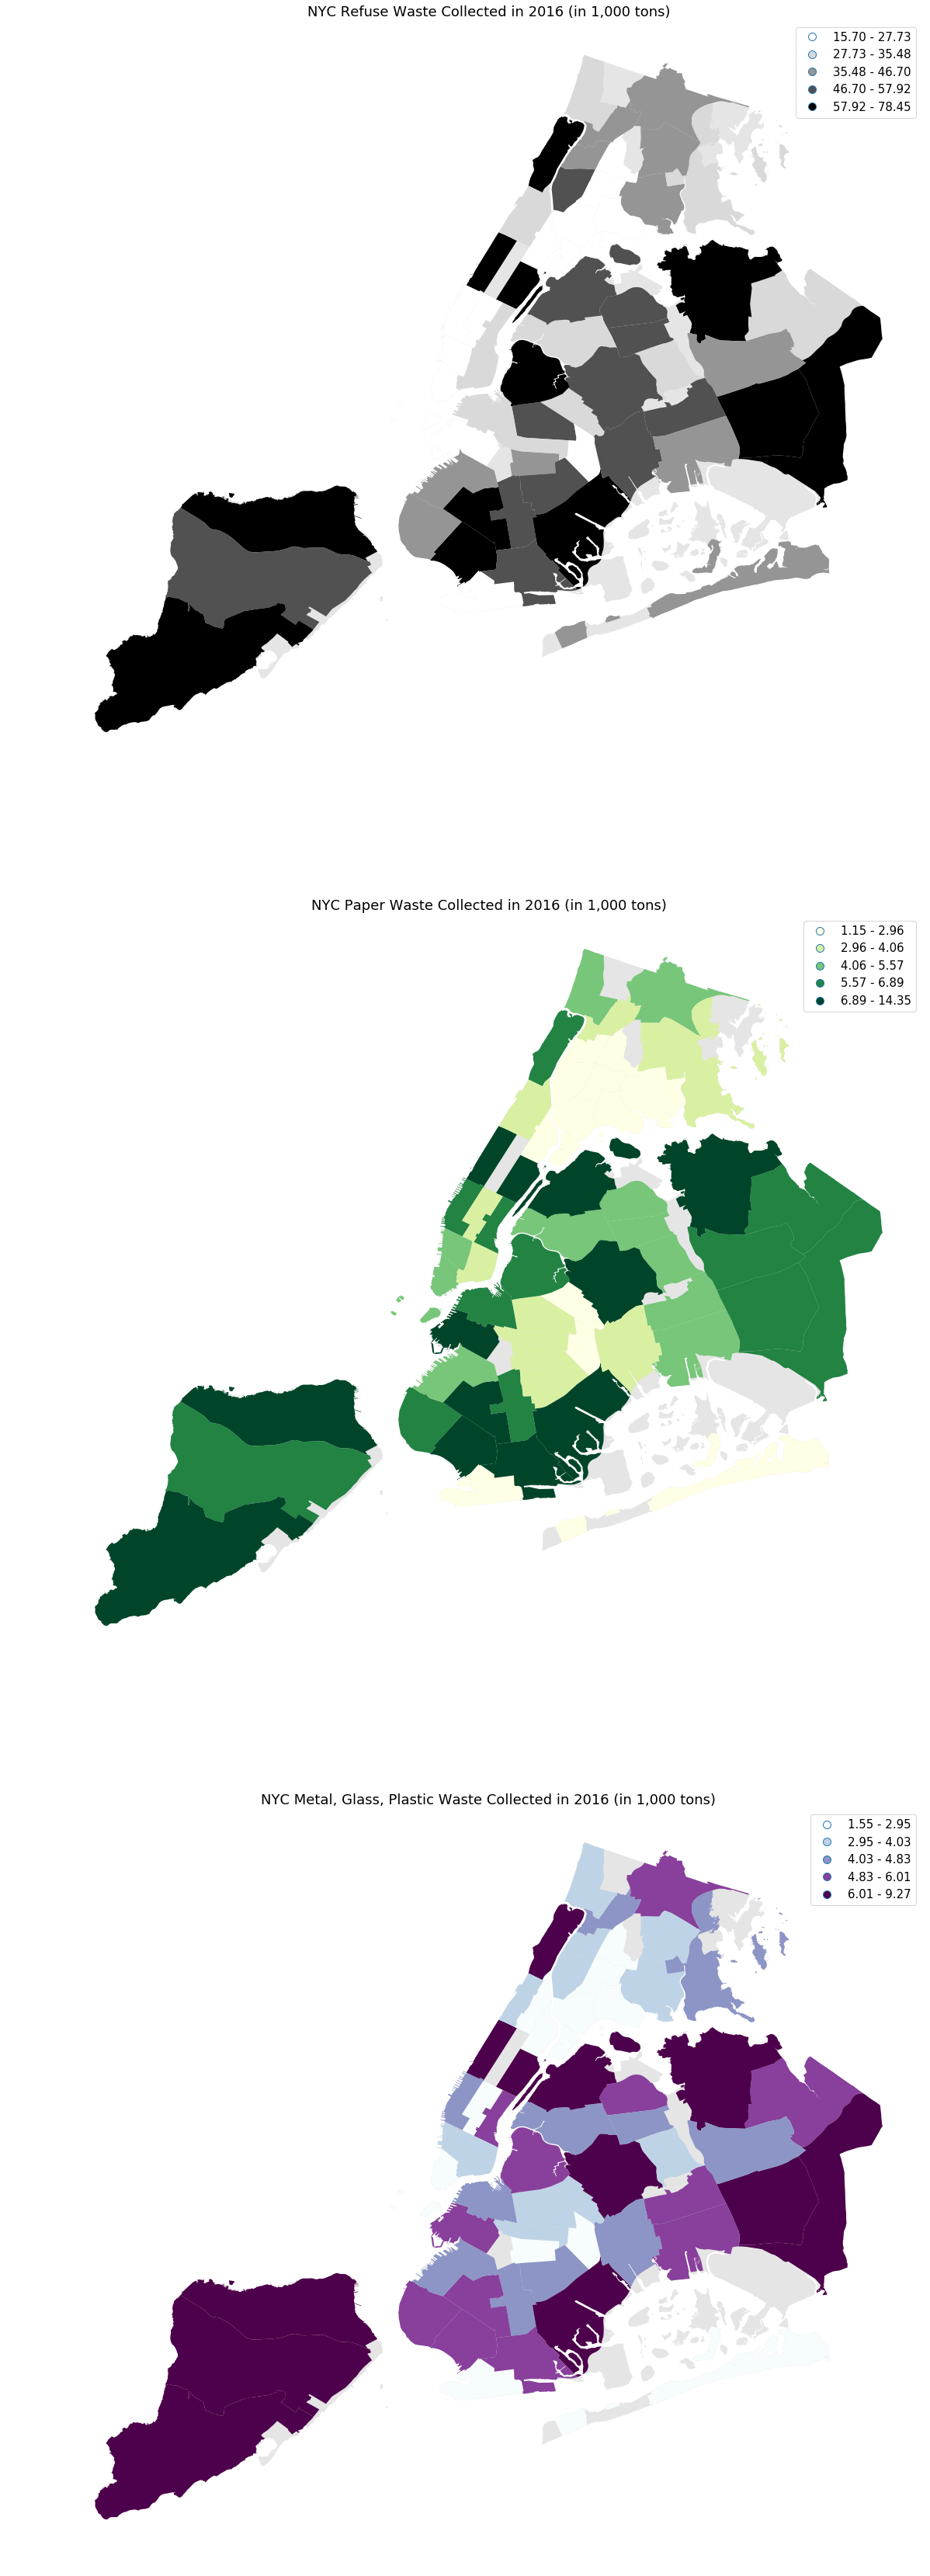

In [160]:
f, (ax1, ax2, ax3) = pl.subplots(3, 1, figsize=(20,60))

df_nyc.plot(ax=ax1, color='black', alpha=0.1)
df_all.plot(ax=ax1, column='REFUSETONSCOLLECTED', cmap='Greys', scheme='quantiles', legend=True)
ax1.set_title('NYC Refuse Waste Collected in 2016 (in 1,000 tons)')
ax1.axis('off')

df_nyc.plot(ax=ax2, color='black', alpha=0.1)
df_all.plot(ax=ax2, column='PAPERTONSCOLLECTED', cmap='YlGn', scheme='quantiles', legend=True)
ax2.set_title('NYC Paper Waste Collected in 2016 (in 1,000 tons)')
ax2.axis('off')

df_nyc.plot(ax=ax3, color='black', alpha=0.1)
df_all.plot(ax=ax3, column='MGPTONSCOLLECTED', cmap='BuPu', scheme='quantiles', legend=True)
ax3.set_title('NYC Metal, Glass, Plastic Waste Collected in 2016 (in 1,000 tons)')
ax3.axis('off')

savefig('2016_trash.png')

In [145]:
years = [2013, 2014, 2015, 2016, 2017]

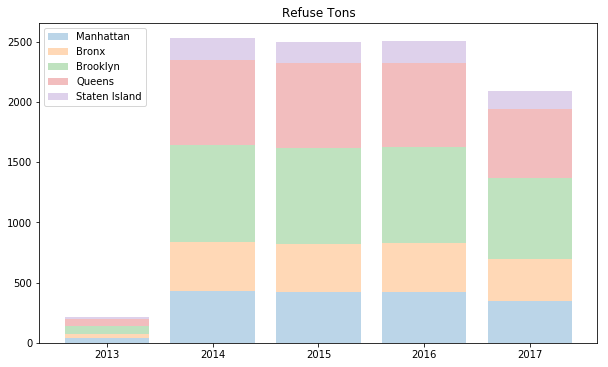

In [146]:
fig = pl.figure(figsize=(10,20))
ax1 = fig.add_subplot(311)

ax1.bar(years, MN.REFUSETONSCOLLECTED, alpha=0.3, label='Manhattan')
ax1.bar(years, BX.REFUSETONSCOLLECTED, alpha=0.3, bottom=MN.REFUSETONSCOLLECTED, label='Bronx')
ax1.bar(years, BK.REFUSETONSCOLLECTED, alpha=0.3, bottom=np.array(MN.REFUSETONSCOLLECTED)+np.array(BX.REFUSETONSCOLLECTED), label='Brooklyn')
ax1.bar(years, QN.REFUSETONSCOLLECTED, alpha=0.3, bottom=np.array(MN.REFUSETONSCOLLECTED)+np.array(BX.REFUSETONSCOLLECTED)+np.array(BK.REFUSETONSCOLLECTED), label='Queens')
ax1.bar(years, SI.REFUSETONSCOLLECTED, alpha=0.3, bottom=np.array(MN.REFUSETONSCOLLECTED)+np.array(BX.REFUSETONSCOLLECTED)+np.array(BK.REFUSETONSCOLLECTED)+np.array(QN.REFUSETONSCOLLECTED), label='Staten Island')
ax1.legend()
ax1.set_title('Refuse Tons')


# ax2 = fig.add_subplot(312)
# ax2.plot(years, MN.PAPERTONSCOLLECTED)
# ax2.plot(years, BX.PAPERTONSCOLLECTED)
# ax2.plot(years, BK.PAPERTONSCOLLECTED)
# ax2.plot(years, QN.PAPERTONSCOLLECTED)
# ax2.plot(years, SI.PAPERTONSCOLLECTED)
# ax2.set_title('Paper Tons')


# ax3 = fig.add_subplot(313)
# ax3.plot(years, MN.MGPTONSCOLLECTED)
# ax3.plot(years, BX.MGPTONSCOLLECTED)
# ax3.plot(years, BK.MGPTONSCOLLECTED)
# ax3.plot(years, QN.MGPTONSCOLLECTED)
# ax3.plot(years, SI.MGPTONSCOLLECTED)